In [44]:
#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

np.random.seed(42) # reproducibility (keep results consistent)

In [45]:
#Loading the dataset
data = pd.read_csv('/marketing_campaign.csv', sep="\t")

print("Number of datapoints:", len(data))
data.head()

Number of datapoints: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [46]:
# Quick dataset check: missing values + dtypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [47]:
# Drop rows with missing values
data = data.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(data))

The total number of data-points after removing the rows with missing values are: 2216


In [48]:
#Convert Dt_Customer to Datetype
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"], dayfirst=True)
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)

In [49]:
#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in therecords:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))

The newest customer's enrolment date in therecords: 2014-06-29
The oldest customer's enrolment date in the records: 2012-07-30


In [50]:
# Build "Customer_For" = days since enrollment (relative to latest date in dataset)

days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

In [12]:
#Check Categories
print("Total categories in the feature Marital_Status:\n", data["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", data["Education"].value_counts())

Total categories in the feature Marital_Status:
 Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64 

Total categories in the feature Education:
 Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64


In [51]:
#Feature Engineering


#Age of customer today
current_year = 2026
data["Age"] = current_year - data["Year_Birth"]

#Total spendings on various items
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

#Deriving living situation by marital status"Alone"
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Feature indicating total children living in the household
data["Children"]=data["Kidhome"]+data["Teenhome"]

#Feature for total members in the household
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

#Feature pertaining parenthood
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

#Segmenting education levels in three groups
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#Rename for clarity
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

/tmp/ipython-input-1546943737.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]


In [52]:
data.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,3.054423e+16,57.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,1.749036e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,30.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,1.555200e+16,49.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,3.071520e+16,56.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,4.570560e+16,67.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,6.039360e+16,133.000000,2525.000000,3.000000,5.000000,1.000000


Relative Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

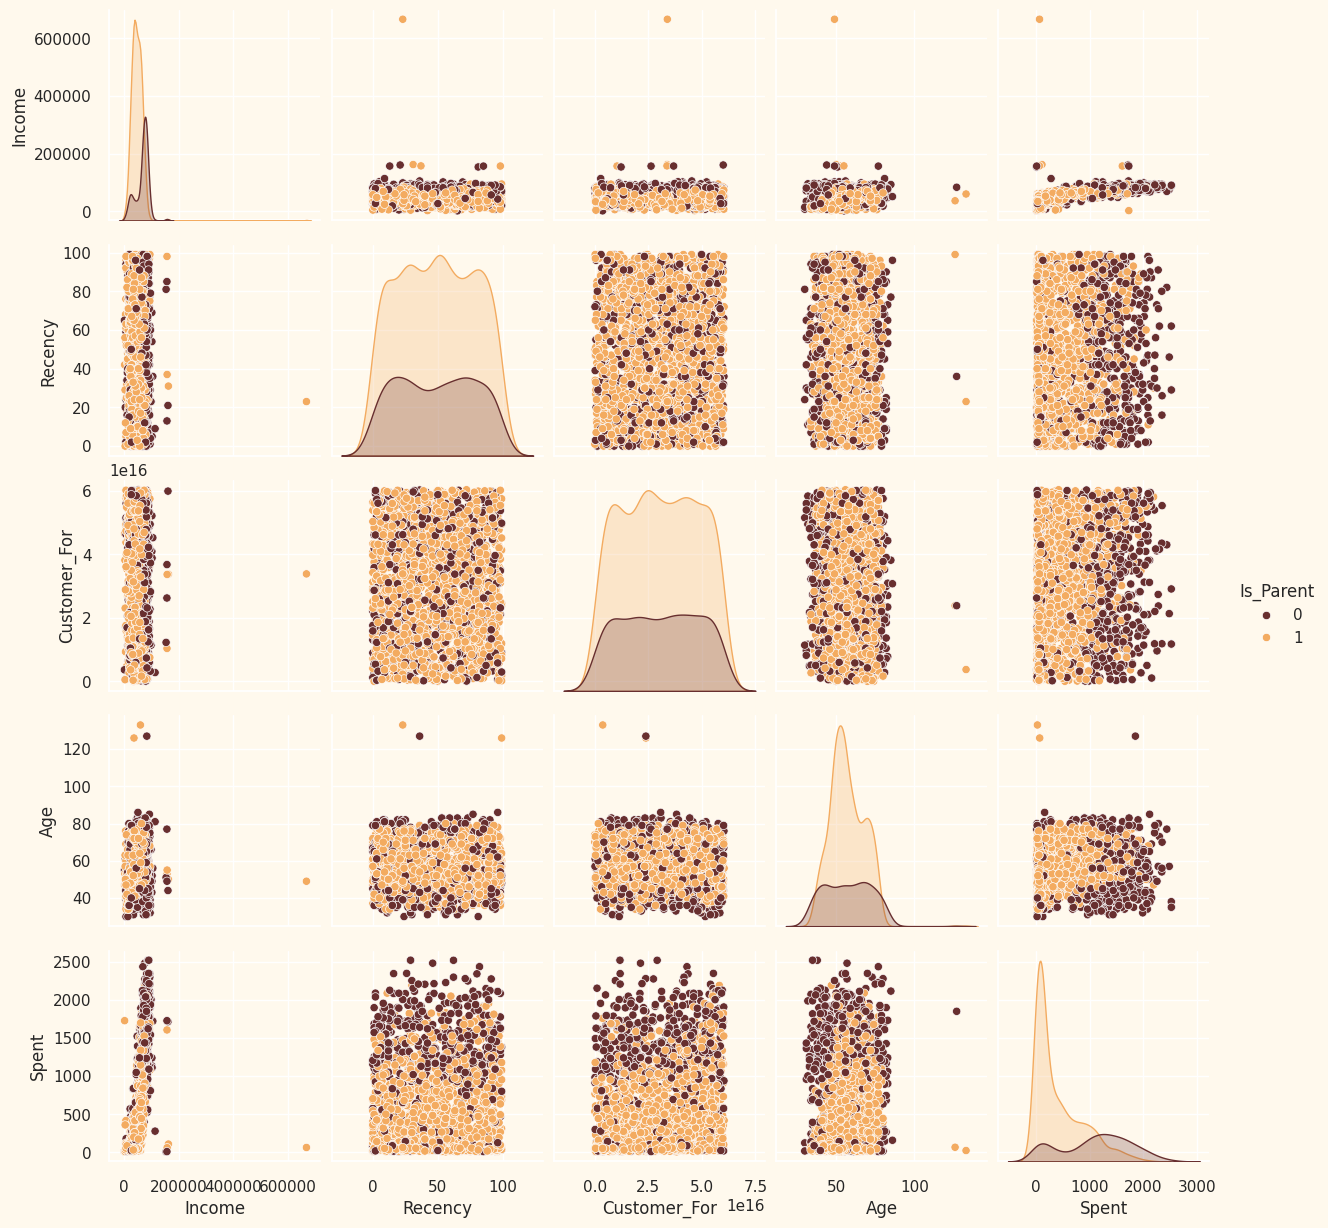

In [54]:
#To plot some selected features

#Setting up colors preferences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

#Plotting following features
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Relative Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(data[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))

#Taking hue
plt.show()

In [16]:
#Dropping the outliers by setting a cap on Age and income.
data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 2212


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2212 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2212 non-null   object 
 1   Income               2212 non-null   float64
 2   Kidhome              2212 non-null   int64  
 3   Teenhome             2212 non-null   int64  
 4   Recency              2212 non-null   int64  
 5   Wines                2212 non-null   int64  
 6   Fruits               2212 non-null   int64  
 7   Meat                 2212 non-null   int64  
 8   Fish                 2212 non-null   int64  
 9   Sweets               2212 non-null   int64  
 10  Gold                 2212 non-null   int64  
 11  NumDealsPurchases    2212 non-null   int64  
 12  NumWebPurchases      2212 non-null   int64  
 13  NumCatalogPurchases  2212 non-null   int64  
 14  NumStorePurchases    2212 non-null   int64  
 15  NumWebVisitsMonth    2212 non-null   int64 

In [56]:
#Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [57]:
#Label Encoding the object dtypes for ML
LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)

print("All features are now numerical")

All features are now numerical


In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2216 non-null   int64  
 1   Income               2216 non-null   float64
 2   Kidhome              2216 non-null   int64  
 3   Teenhome             2216 non-null   int64  
 4   Recency              2216 non-null   int64  
 5   Wines                2216 non-null   int64  
 6   Fruits               2216 non-null   int64  
 7   Meat                 2216 non-null   int64  
 8   Fish                 2216 non-null   int64  
 9   Sweets               2216 non-null   int64  
 10  Gold                 2216 non-null   int64  
 11  NumDealsPurchases    2216 non-null   int64  
 12  NumWebPurchases      2216 non-null   int64  
 13  NumCatalogPurchases  2216 non-null   int64  
 14  NumStorePurchases    2216 non-null   int64  
 15  NumWebVisitsMonth    2216 non-null   int64 

In [59]:
#Scaling Process

#Creating a copy of data for scaling
ds = data.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)

#Scaling features
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


In [60]:
#Scaled data
print("Dataframe to be used for further modelling:")
scaled_ds.head()

Dataframe to be used for further modelling:


,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.894187,0.234063,-0.823039,-0.928972,0.310532,0.978226,1.549429,1.690227,2.454568,1.484827,...,2.504712,-0.554143,0.693232,1.529129,0.986443,1.675488,-1.348829,-1.264803,-1.758673,-1.581389
1,-0.894187,-0.234559,1.039938,0.909066,-0.380509,-0.872024,-0.637328,-0.717986,-0.651038,-0.633880,...,-0.571082,-1.169518,-0.131574,-1.188411,1.236801,-0.962358,-1.348829,1.405806,0.450009,0.632356
2,-0.894187,0.769478,-0.823039,-0.928972,-0.795134,0.358511,0.569159,-0.178368,1.340203,-0.146821,...,-0.229327,1.291982,-0.543978,-0.205155,0.318822,0.280250,0.741384,-1.264803,-0.654332,-1.581389
3,-0.894187,-1.017239,1.039938,-0.928972,-0.795134,-0.872024,-0.561922,-0.655551,-0.504892,-0.585174,...,-0.912837,-0.554143,0.280829,-1.059945,-1.266777,-0.919224,0.741384,0.070501,0.450009,0.632356
4,0.569268,0.240221,1.039938,-0.928972,1.554407,-0.391671,0.418348,-0.218505,0.152766,-0.000703,...,0.112428,0.061232,-0.131574,-0.951244,-1.016420,-0.307044,0.741384,0.070501,0.450009,0.632356


In [23]:
#Reduce dimensions with PCA (3 components)

In [62]:
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2216.0,3.847704e-17,2.850029,-5.881402,-2.489399,-0.795923,2.428345,7.390967
col2,2216.0,-3.847704e-17,1.701845,-4.169993,-1.317389,-0.186333,1.232919,6.140581
col3,2216.0,-2.645297e-17,1.228078,-5.047339,-0.845538,-0.048713,0.866136,6.717940


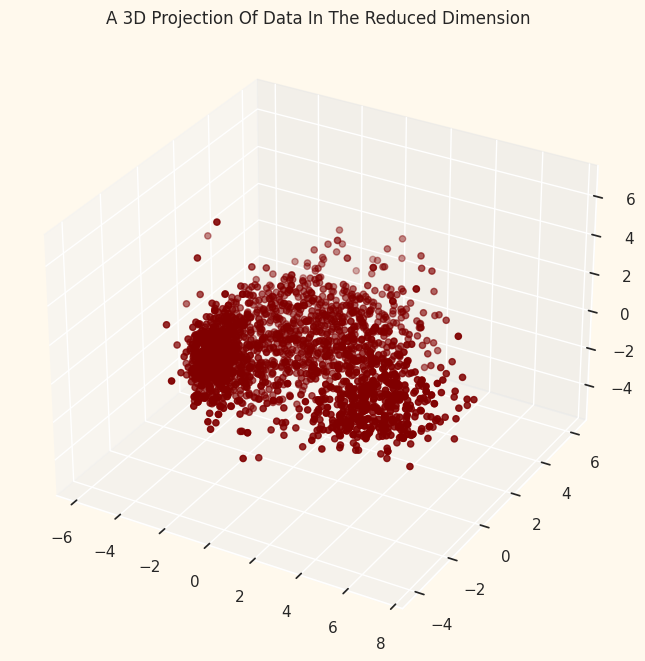

In [63]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

Elbow Method to determine the number of clusters to be formed:


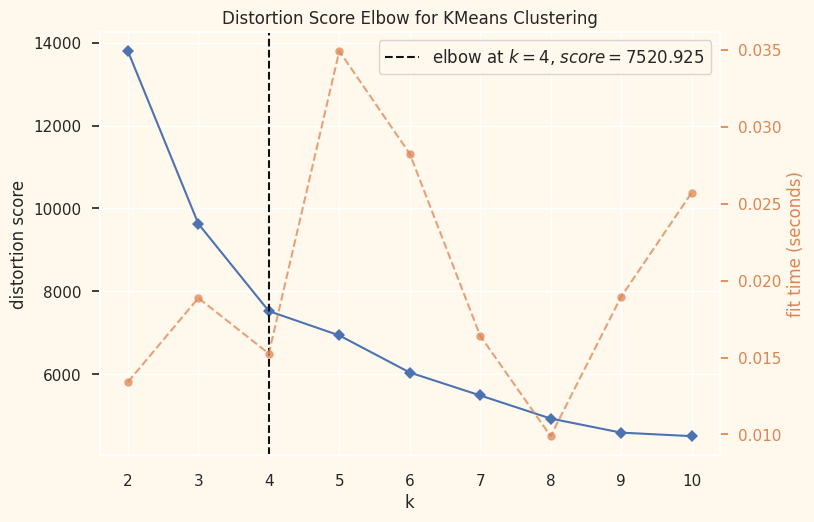

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [64]:
# Elbow method to find optimal number of clusters
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [34]:
# The distortion score(blue line) drops sharply until k = 4 and flattens afterward,
# indicating diminishing returns beyond this point.
# Thus, k = 4 is chosen as the optimal number of clusters.

In [65]:
#Initiating the Agglomerative Clustering model
AC = AgglomerativeClustering(n_clusters=4)

# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC

#Adding the Clusters feature to the orignal dataframe.
data["Clusters"]= yhat_AC

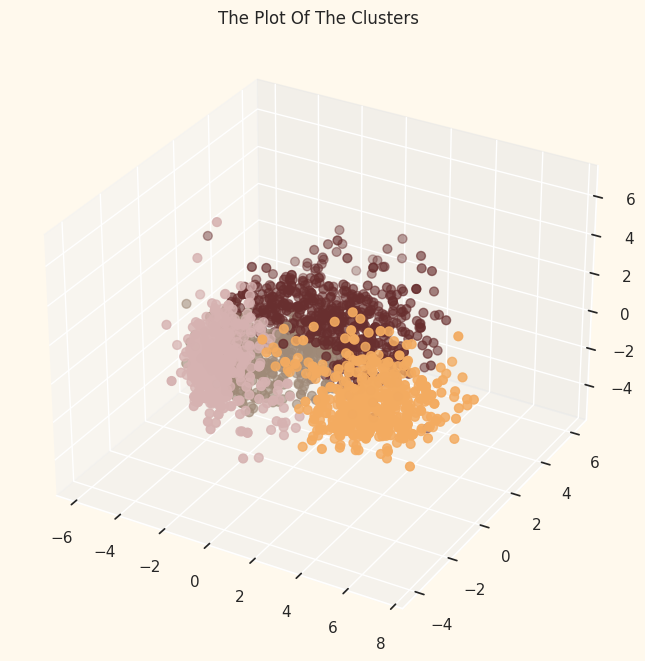

In [66]:
# 3D visualization of clusters (PCA space)
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

/tmp/ipython-input-1859745431.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.countplot(x=data["Clusters"], palette= pal)


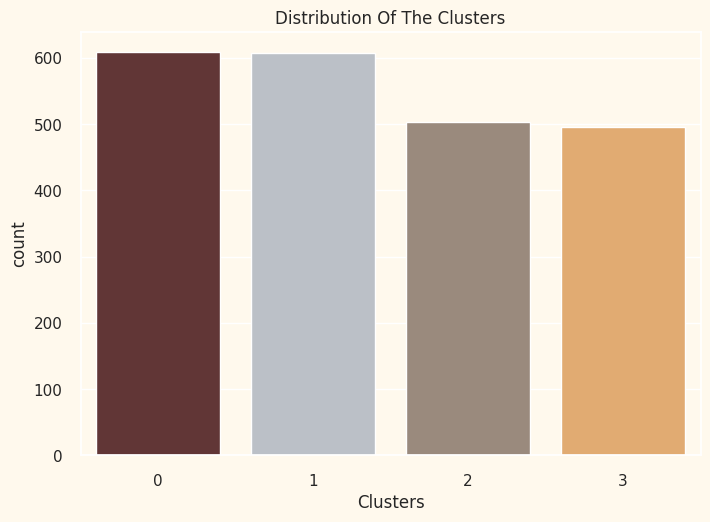

In [67]:
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=data["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

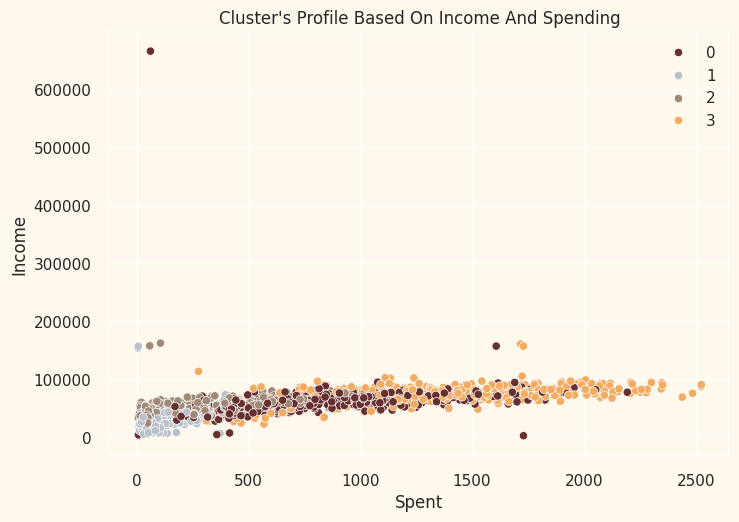

In [69]:
# Cluster profiling: Income vs Spending
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()


/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py:3399: UserWarning: 11.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py:3399: UserWarning: 71.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/seaborn/categorical.py:3399: UserWarning: 45.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/tmp/ipython-input-3501506979.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl=sns.boxenplot(x=data["Clusters"], y=data["Spent"], palette=pal)
/usr/local/lib/python3.12/dist-packages/seaborn/c

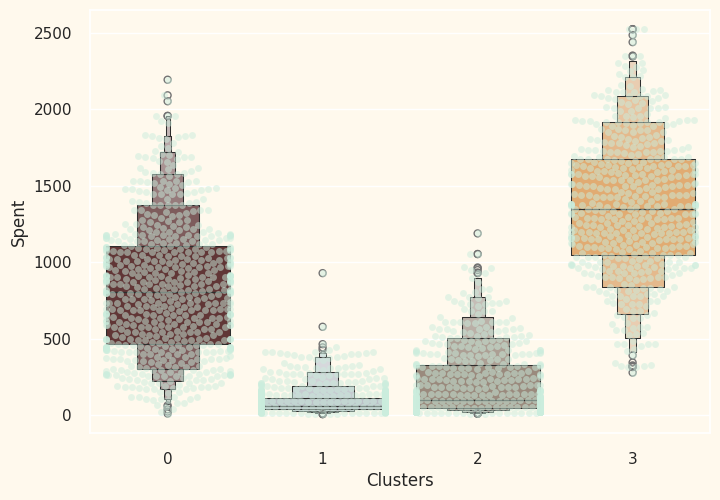

In [70]:
# Spending distribution by cluster
plt.figure()
pl=sns.swarmplot(x=data["Clusters"], y=data["Spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=data["Clusters"], y=data["Spent"], palette=pal)
plt.show()

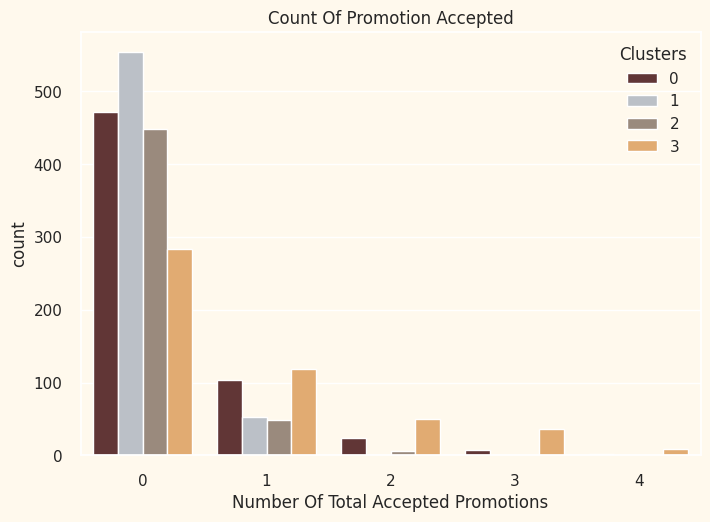

In [71]:
# Promotion engagement feature

#Creating a feature to get a sum of accepted promotions
data["Total_Promos"] = data["AcceptedCmp1"]+ data["AcceptedCmp2"]+ data["AcceptedCmp3"]+ data["AcceptedCmp4"]+ data["AcceptedCmp5"]
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=data["Total_Promos"],hue=data["Clusters"], palette= pal)
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

/tmp/ipython-input-2174481357.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl=sns.boxenplot(y=data["NumDealsPurchases"],x=data["Clusters"], palette= pal)


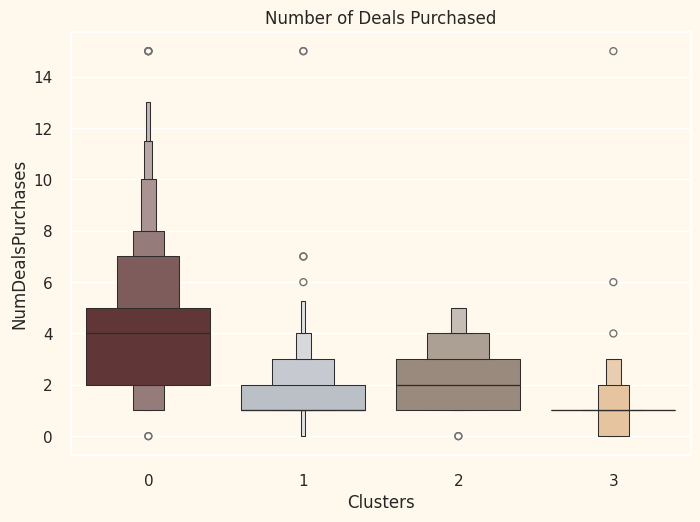

In [72]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=data["NumDealsPurchases"],x=data["Clusters"], palette= pal)
pl.set_title("Number of Deals Purchased")
plt.show()

<Figure size 800x550 with 0 Axes>

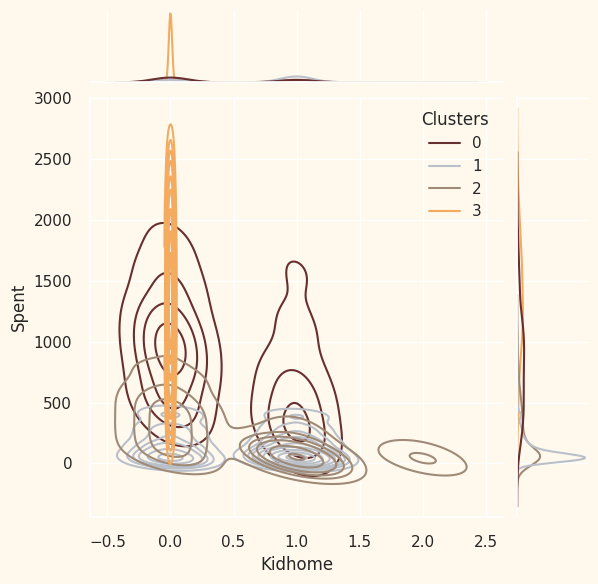

/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1883: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)


<Figure size 800x550 with 0 Axes>

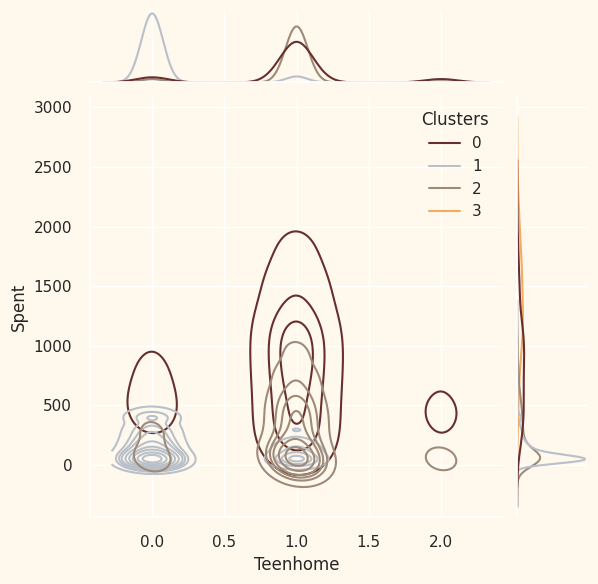

<Figure size 800x550 with 0 Axes>

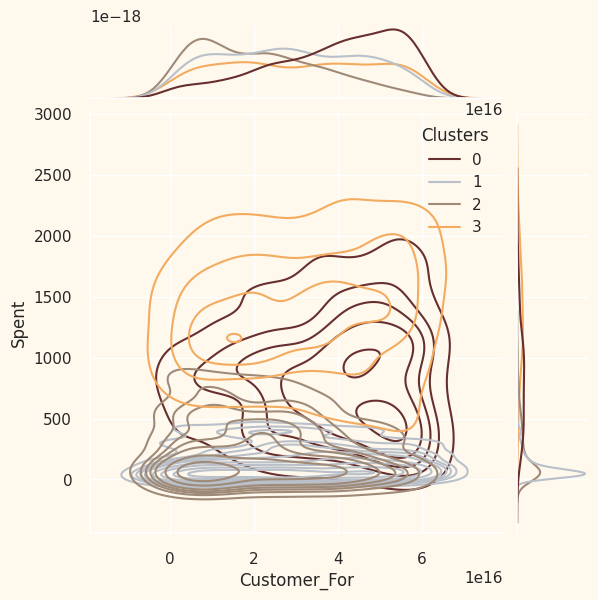

<Figure size 800x550 with 0 Axes>

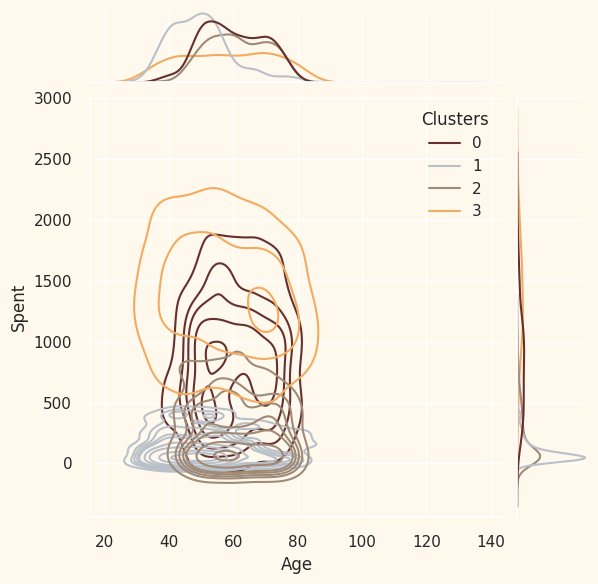

<Figure size 800x550 with 0 Axes>

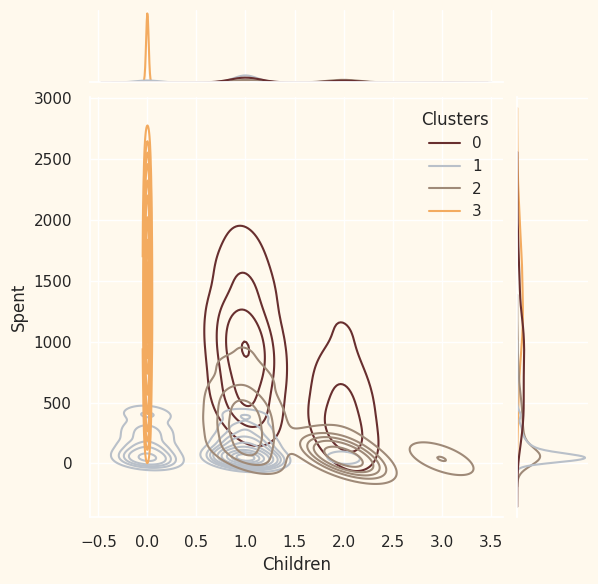

<Figure size 800x550 with 0 Axes>

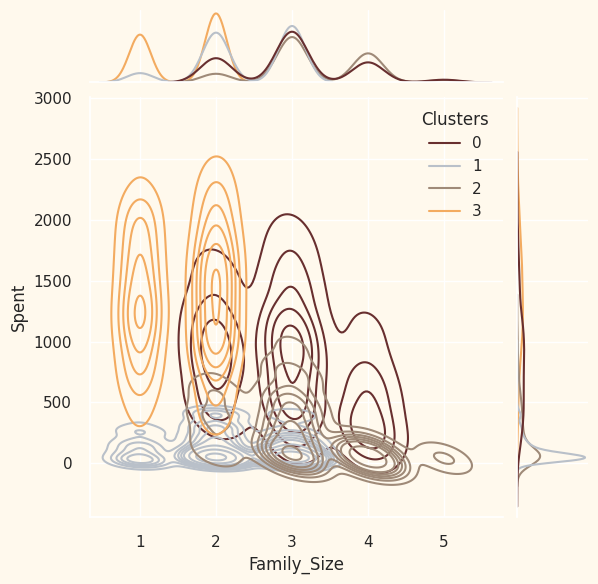

/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:1883: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)


<Figure size 800x550 with 0 Axes>

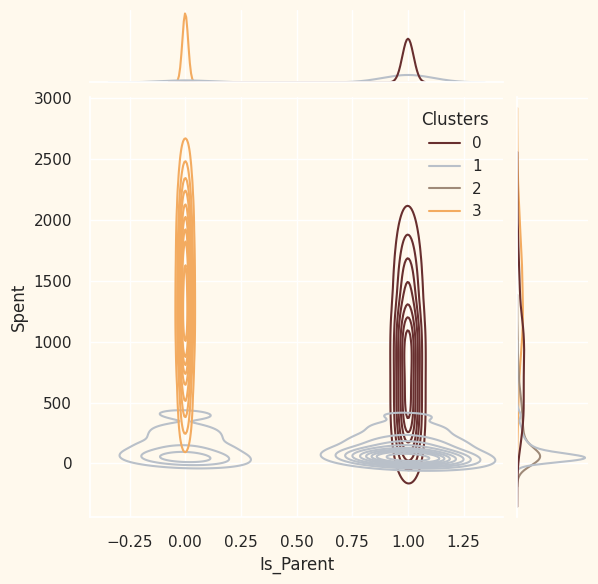

<Figure size 800x550 with 0 Axes>

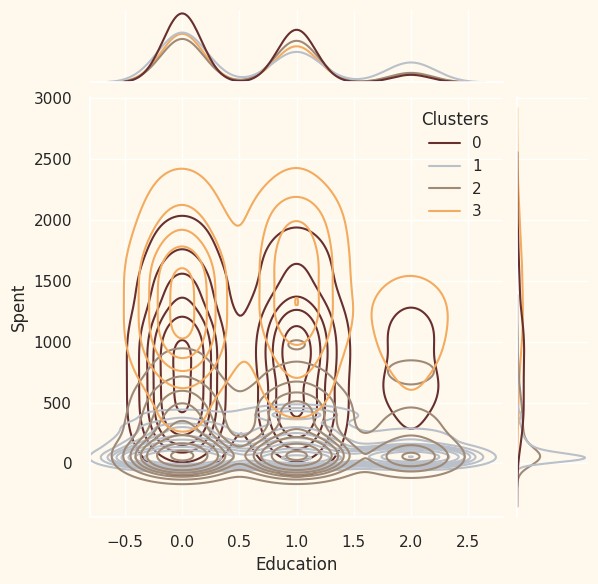

<Figure size 800x550 with 0 Axes>

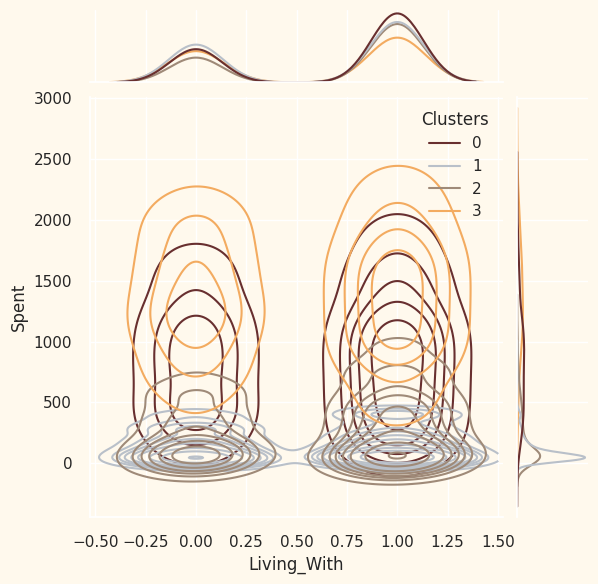

In [74]:
# Personal and demographic features vs spending

Personal = [ "Kidhome","Teenhome","Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education","Living_With"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=data[i], y=data["Spent"], hue =data["Clusters"], kind="kde", palette=pal)
    plt.show()